In [1]:
from jax import numpy as jnp, random, jit
import phayes
import matplotlib.pyplot as plt

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

# True $\phi$

We'll specify a true underlying phase and then recover it.

In [3]:
true_phi = 0.82

# Protocol for simulating measurements

In [4]:
def run_experiment(k: int, beta: float, n_shots: int, random_key: random.PRNGKeyArray) -> jnp.ndarray:
    p0 =  0.5 * (1 + jnp.cos(k * true_phi + beta))
    return random.choice(random_key, a=jnp.arange(2), p=jnp.array([p0, 1-p0]), shape=(n_shots,))

# Run experiment

We initiate a `PhayesState` that adaptively encodes a Fourier series distribution or a von Mises distribution once the number of terms in the Fourier series becomes prohibitively large.

Here we'll set the Fourier series limit to $J=100$ coefficients to demonstrate the adaptive conversion to von Mises. In practice `phayes` (with `jit`) is still fast (and more accurate) with more coefficients - it defaults to $J=500$.

In [5]:
state = phayes.init(J=100)
state

PhayesState(fourier_mode=True, fourier_coefficients=Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float64), von_mises_paramet

In [6]:
n_shots_per_experiment = 1
num_experiments = 20
k_max = jnp.inf
random_keys = random.split(random.PRNGKey(0), num_experiments)

Now we can run the experiment to recover the true phase

In [7]:
states = [state]
ks = []
betas = []
for i in range(num_experiments):
    k, beta = jit(phayes.get_k_and_beta)(states[i], k_max=k_max)
    ks.append(k)
    betas.append(beta)
    m = run_experiment(k, beta, n_shots_per_experiment, random_keys[i])
    new_state = jit(phayes.update)(states[i], m, k, beta)
    states.append(new_state)
    mode = 'Fourier' if states[i+1].fourier_mode else 'von Mises'
    print(f"Experiment {i+1}/{num_experiments}: k={k}, {mode}, Holevo variance={phayes.holevo_variance(states[i+1])}")

Experiment 1/20: k=1, Fourier, Holevo variance=3.0
Experiment 2/20: k=1, Fourier, Holevo variance=0.9999999999999996
Experiment 3/20: k=1, Fourier, Holevo variance=0.5609754119766719
Experiment 4/20: k=2, Fourier, Holevo variance=0.2791550787133148
Experiment 5/20: k=2, Fourier, Holevo variance=0.21525487863253168
Experiment 6/20: k=3, Fourier, Holevo variance=0.1724758167534497
Experiment 7/20: k=1, Fourier, Holevo variance=0.0856661343892835
Experiment 8/20: k=4, Fourier, Holevo variance=0.05855405722327145
Experiment 9/20: k=6, Fourier, Holevo variance=0.037280909477750646
Experiment 10/20: k=7, Fourier, Holevo variance=0.03143601188088052
Experiment 11/20: k=3, Fourier, Holevo variance=0.015851104311632724
Experiment 12/20: k=11, Fourier, Holevo variance=0.01105891281746807
Experiment 13/20: k=15, Fourier, Holevo variance=0.012849154744120073
Experiment 14/20: k=19, Fourier, Holevo variance=0.011896519334016142
Experiment 15/20: k=34, von Mises, Holevo variance=0.011952093122010288

Let's plot the results

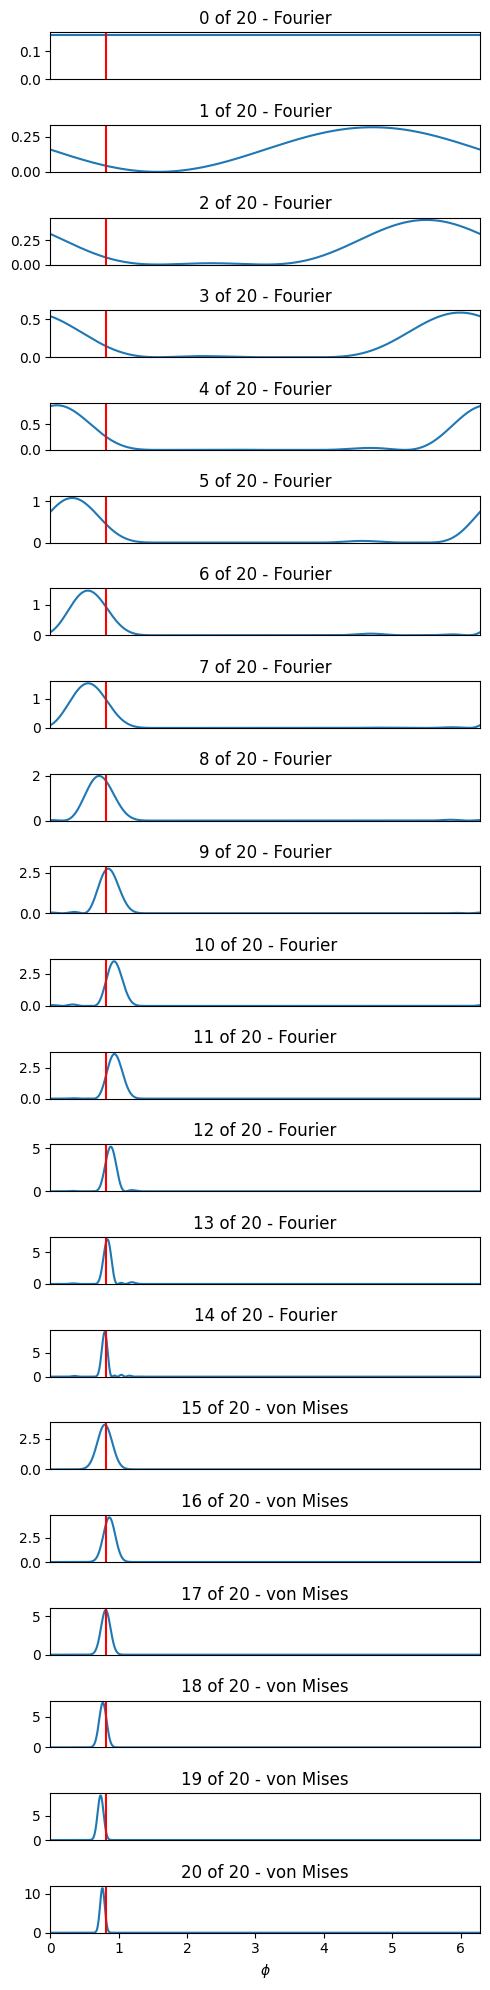

In [8]:
pdf_linsp = jnp.linspace(0, 2 * jnp.pi, 1000)

fig, axes = plt.subplots(num_experiments + 1, figsize=(5, num_experiments))
for i, s in enumerate(states):
    mode = 'Fourier' if states[i].fourier_mode else 'von Mises'
    axes[i].plot(pdf_linsp, phayes.pdf(pdf_linsp, s), label=f"Step {i}")
    axes[i].axvline(true_phi, c='red')
    axes[i].set_title(f"{i} of {num_experiments} - {mode}")
    axes[i].set_xlim(0, 2 * jnp.pi)
    axes[i].set_ylim(0, axes[i].get_ylim()[1])
    if i < num_experiments:
        axes[i].set_xticks([])
axes[-1].set_xlabel(r"$\phi$")
fig.tight_layout()